In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from toy_vae import VAE
from utils import generate_ring, generate_linear

In [2]:
def compute_loss(model, x):
    z_mean, z_logvar, x_f = model.sampling(x)
    kl_divergance = 0.5*tf.reduce_sum(tf.square(z_mean)+tf.square(z_logvar)-tf.math.log(1e-8+tf.square(z_logvar))-1, 1)
    marginal_likelihood = tf.reduce_sum(x*tf.math.log(x_f)+(1-x)*tf.math.log(1-x_f), 1)
    kl_divergance = tf.reduce_mean(kl_divergance)
    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    ELBO = marginal_likelihood - kl_divergance
    loss = -ELBO

    return loss, kl_divergance, marginal_likelihood

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss, _, _ = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [3]:
def show_results_with_dataset(model, epoch, dataset):
    _, _, x_f = model.sampling(dataset)

    plt.figure(2)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.scatter(dataset[:,0], dataset[:,1], alpha=.5, color='cornflowerblue')
    plt.scatter(x_f[:, 0], x_f[:,1], alpha=.5, color='maroon')
    plt.axis('equal')
    plt.savefig('./results/{:04d}.png'.format(epoch))
    plt.cla()

In [4]:
dataset_size = 5000
train_set_size, test_set_size = 4000, 1000
batch_size = 32

# Sampling Linear Dataset
dataset = generate_linear(dataset_size)

# Sampling Ring Dataset
# dataset = generate_ring(dataset_size)

# Scaling Dataset
scaler = preprocessing.MinMaxScaler()
scaled_dataset = scaler.fit_transform(dataset)

train_x, test_x = scaled_dataset[:train_set_size], scaled_dataset[train_set_size:]
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(train_set_size).batch(batch_size)
train_dataset = tf.data.Dataset.from_tensor_slices(test_x).shuffle(test_set_size).batch(batch_size)

for test_batch in train_dataset.take(1):
    test_sample = test_batch[:test_set_size]

In [5]:
# Make Model
z_dims = 10
model = VAE(z_dims=z_dims)
optimizer = tf.keras.optimizers.Adam(1e-5)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


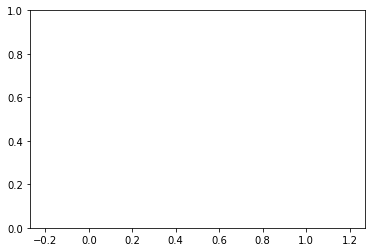

In [6]:
epochs = 200
for epoch in range(1, epochs):
    for train_data in train_dataset:
        train_step(model, train_data, optimizer)
    # print(epoch)
    show_results_with_dataset(model, epoch, test_sample)